In [176]:
%matplotlib ipympl

### Import the needed modules

In [177]:
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Bring and plot your EIS data here
Check if its has come as it is

your first column should contain the frequency values, second column should contain the real part of the impedance, the third column should contain the imaginary part of the impedance

Please order the data in either ascending or descending order of frequency values

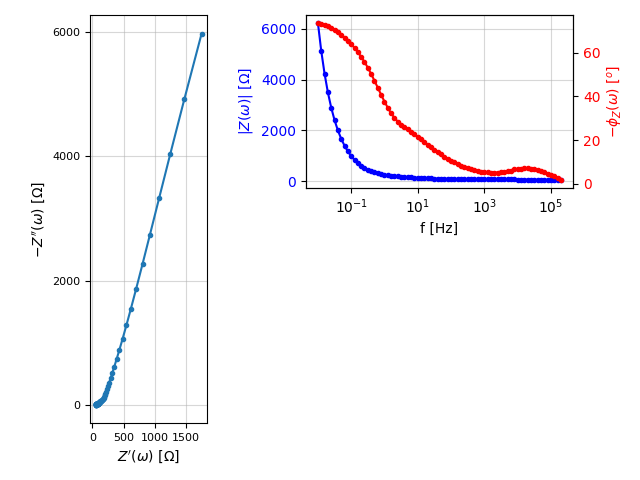

In [178]:
freq, zexp = readBioLogic("exampleData.mpt")
#freq1, zexp = readCSV("hello.csv")

##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
ax_mag.plot(freq, np.abs(zexp), '.-', color="blue")
ax_phs.plot(freq, -np.angle(zexp, deg=True), '.-',color="red")
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color="blue")
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color="red")
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor="blue")
ax_phs.tick_params(axis='y', labelcolor="red")
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### Provide the frequency range in which you want to fit

In [179]:
f_high=1e4
f_low=1e-1
fhigh_idx=find_index_of_nearest(freq,f_high)
flow_idx=find_index_of_nearest(freq,f_low)
print(fhigh_idx," ",flow_idx)

#crop the data that falls in this frequency range
if(fhigh_idx<flow_idx):
    freq_to_fit=freq[fhigh_idx:flow_idx]
    zexp_to_fit=zexp[fhigh_idx:flow_idx]
else:
    freq_to_fit=freq[flow_idx:fhigh_idx]
    zexp_to_fit=zexp[flow_idx:fhigh_idx]



13   63


##### See the data for the freq range that you have choosen

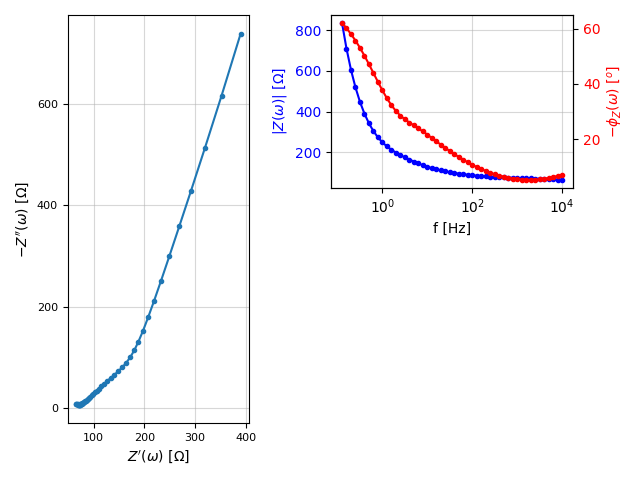

In [180]:
##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

#### Choose the inhomogenity profile of tortuosity and provide the initial guesses for the parameters
The following profiles are available

1. Uniform tortuosity
2. Two-Step inhomogenity in tortuosity
3. Three-Step
4. Linearly varying toruosity
5. Inverse-Linear

You can also select all the profiles at once and see which one fits better:
using the ...........(to be conti.)


In [181]:
#initial guesses for the TLM
Q=1e-6
alpha=0.98

R1=500
delta1=0.3
R2=100
R3=500
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=0.95

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

In [182]:
#---uncomment the line below for fitting the uniform tortuosity profile---
#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")

### Choose weighing method and the algorithm for the fitting

In [183]:
wt="unit"
#wt="mod"
#wt="prop"

In [190]:
def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
#cmodel.fit(impedance=zexp,frequencies=freq,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0.5),(np.inf,np.inf,1)])
cmodel.fit(impedance=zexp,frequencies=freq,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0.5,0,0,0,0.5),(np.inf,np.inf,np.inf,1,1,np.inf,np.inf,np.inf,1)])
#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])
#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])
print(cmodel)



Circuit string: TLMtwo_1-R_1-p(R_2,CPE_1)
Fit: True

Initial guesses:
  TLMtwo_1_0 = 5.00e+02 [Ohm]
  TLMtwo_1_1 = 5.00e-04 [Ohm F]
  TLMtwo_1_2 = 1.00e-04 [Ohm F]
  TLMtwo_1_3 = 3.00e-01 []
  TLMtwo_1_4 = 9.80e-01 []
    R_1 = 4.00e+01 [Ohm]
    R_2 = 4.00e+01 [Ohm]
  CPE_1_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE_1_1 = 9.50e-01 []

Fit parameters:
  TLMtwo_1_0 = 1.68e+02  (+/- 2.67e+00) [Ohm]
  TLMtwo_1_1 = 5.63e-01  (+/- 9.32e-03) [Ohm F]
  TLMtwo_1_2 = 9.11e+01  (+/- 1.44e+01) [Ohm F]
  TLMtwo_1_3 = 8.44e-01  (+/- 7.92e-03) []
  TLMtwo_1_4 = 8.43e-01  (+/- 5.23e-04) []
    R_1 = 5.17e+01  (+/- 1.55e+00) [Ohm]
    R_2 = 1.13e+01  (+/- 1.79e+00) [Ohm]
  CPE_1_0 = 6.00e-07  (+/- 9.57e-07) [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00  (+/- 1.45e-01) []

0


### Print the parameters of the model with their actual names

In [196]:
def print_model(circuit):
    if(circuit._is_fit()):
        print("The circuit is fit already")
        print("\nBelow we are printing the values of parameters for the circuit\n")
        param=cmodel.parameters_
        cname=cmodel.circuit
        if(cname.find("TLMtwo")>=0):
            print("R1 : ",param[0])
            print("R2 : ",param[2]*param[0]/param[1])
            print("Q : ",param[1]/param[0])
            print("δ1 : ",param[3])
            print("α : ",param[4])
            print("Rhfr : ",param[5])
            print("Rrxn : ",param[6])
            print("Q2 : ",param[7])
            print("α2 : ",param[8])
        # if(cname.find("TLMthree")>=0):
        #     print()
        # if(cname.find("TLMlin")>=0):
        #     print()
        # if(cname.find("TLMilin")>=0):
        #     print()
    else:
        print("The circuit is not fit yet")
        
print_model(circuit=cmodel)

The circuit is fit already

Below we are printing the values of parameters for the circuit

R1 :  167.81429251518713
R2 :  27163.046949297022
Q :  0.003353295767210913
δ1 :  0.843909083970131
α :  0.8428637073824226
Rhfr :  51.718817169354445
Rrxn :  11.250978500033662
Q2 :  5.997646989130197e-07
α2 :  0.9999999999999999


In [199]:
f_high=1e4
f_low=1e-1
ff=np.logspace(4,-1)
z_fit=cmodel.predict(frequencies=ff)

### See how the model fits to the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


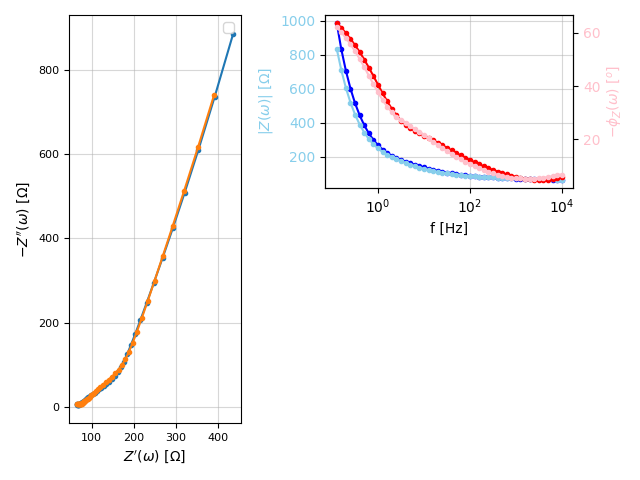

In [204]:


##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(z_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(z_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(z_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()


########
##-----------##
#put the nyquist and the bode plot on the same figure

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="SkyBlue"
phs_color="pink"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### missed some data points while fitting

### Notes
Change the print function to directly print name of the parameters


In [ ]:
# def profile_plotter(circuit,ax):
    
#     if(circuit._is_fit()):
#         param=circuit.parameters_
#     else:
#         param=circuit.initial_guess
#     profile=circuit.circuit

#     ax1=ax
#     if(profile=="TLMtwo"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        delta1=param[3]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        ax1.plot([0,delta1,delta1,1],[R1,R1,R2,R2],linewidth=2,color="red",label="Actual")
    
#     if(profile=="TLMthree"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R3Q=param[3]
#        delta1=param[4]
#        delta2=param[5]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        R3=R3Q/Q
#        ax1.plot([0,delta1,delta1,delta2+delta1,delta2+delta1,1],[R1,R1,R2,R2,R3,R3],linewidth=2,color="blue",label="Actual")

#     if(profile=="TLMlin" or profile=="TLMlinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="green",label="Fit (clean)")

#     if(profile=="TLMilin" or profile=="TLMilinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="blue",label="Fit (noise)")
#        def give_ilin_R(r1,r2,delta):
#         return 1/(1/r1+(1/r2-1/r1)*delta)
#        dlt=np.linspace(0,1,50)
#        ax1.plot(dlt,give_ilin_R(R1,R2,dlt),linewidth=2,color="grey",label="Fitted 1")

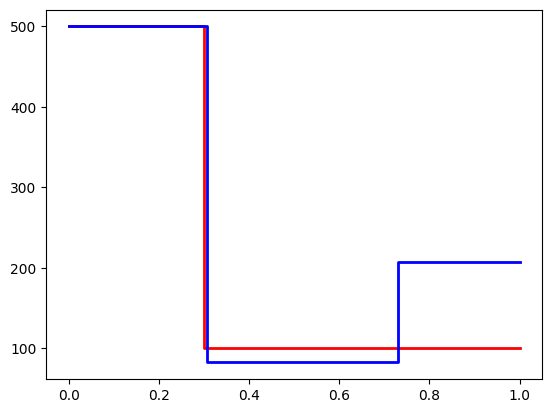

In [ ]:
from models import *
fig, ax= plt.subplots()
profile_plotter(circuit=c1,ax=ax)
profile_plotter(circuit=cthree,ax=ax)
plt.show()
# print(cthree)
# ztwo1=c1.predict(frequencies=f)
# zthree1=cthree.predict(frequencies=f)
# fig, ax1 = plt.subplots()
# models.error_plotter(f,ztwo1,zthree1,ax=ax1)